# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
### by Arjun Chandra
***

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=1):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines #line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Lane Finding Pipeline

In [32]:
# Pipeline to draw lane lines, both hough detected and processed (single lines) on the 
# test_images and videos.
# All images and videos saved in respective test directories.

# Globals to keep track of previous lines
left_line, right_line = np.zeros(4), np.zeros(4)

def line_diff(x, y):
    """Compute distane between endpoints of lines x and y. This is 
    not necessarily the ideal way to figure out the difference 
    between two lines. Perhaps a combination of shortest distance 
    between points on each line and slope of the line could be a
    better, more general, alternative."""
    dist = [(a - b)**2 for a, b in zip(x, y)]
    dist = math.sqrt(sum(dist))
    return dist

def linear_comb(new_avg_left, prev_avg_left, new_avg_right, prev_avg_right):
    """Linearly combine current and previous average if difference 
    below threshold and previous not all 0"""
    
    if not np.any(prev_avg_left):
        avg_line_left = new_avg_left
    else:
        if line_diff(prev_avg_left, new_avg_left) > 50.5: # threshold, 50.5
            avg_line_left = prev_avg_left
        else:
            avg_line_left = (0.3 * prev_avg_left + 0.7 * new_avg_left)
        
    if not np.any(prev_avg_right):
        avg_line_right = new_avg_right
    else:
        if line_diff(prev_avg_right, new_avg_right) > 50.5: # threshold 50.5
            avg_line_right = prev_avg_right
        else:
            avg_line_right = (0.3 * prev_avg_right + 0.7 * new_avg_right)

    return avg_line_left, avg_line_right
            
def average_raw_lines(lines, prev_avg):
    """Merge unordered lines into an single average line.
    In addition, if the average line is within a threshold 
    distance from previous average, return a linear combination 
    of the two. Otherwise, disregard it and return the previous 
    average."""
    right_side = []
    left_side = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2-y1)/(x2-x1)
        if slope < 0:
            left_side.append(line[0])
        else:
            right_side.append(line[0])
    
    prev_avg_left, prev_avg_right = prev_avg

    if len(left_side) == 0:
        new_avg_left = prev_avg_left
    else:
        new_avg_left = np.round(np.mean(np.array(left_side), axis=0)) # simple average
 
    if len(right_side) == 0:
        new_avg_right = prev_avg_right
    else:
        new_avg_right = np.round(np.mean(np.array(right_side), axis=0)) # simple average
        
    return linear_comb(new_avg_left, prev_avg_left, new_avg_right, prev_avg_right)

def linear_weighted_average_raw_lines(lines, prev_avg):
    """Focus weights on lines closer to windshield (i.e. ordered 
    vertically) when averaging. In addition, if the average line
    is within a threshold distance from previous average, return 
    a linear combination of the two. Otherwise, disregard it and 
    return the previous average.
    The weights considered here linearly decrease with distance 
    from windshield, i.e. decreasing y. This is done so 
    as to focus on more prominent parts of the lanes.
    """
    right_side = []
    left_side = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2-y1)/(x2-x1)
        if slope < 0:
            left_side.append(line[0])
        else:
            right_side.append(line[0])
            
    left_compact = np.array(left_side)
    right_compact = np.array(right_side)
    
    prev_avg_left, prev_avg_right = prev_avg
    
    if len(left_side) == 0:
        new_avg_left = prev_avg_left
    else:
        left_compact_y1_sorted = left_compact[np.argsort(np.transpose(left_compact)[::-1][2])]
        new_avg_left = np.round(np.average(left_compact_y1_sorted, axis=0, weights=np.arange(len(left_compact_y1_sorted))+1)) #linearly weighted average
    
    if len(right_side) == 0:
        new_avg_right = prev_avg_right
    else:
        right_compact_y2_sorted = right_compact[np.argsort(np.transpose(right_compact)[::-1][0])]    
        new_avg_right = np.round(np.average(right_compact_y2_sorted, axis=0, weights=np.arange(len(right_compact_y2_sorted))+1)) #linearly weighted average
                
    return linear_comb(new_avg_left, prev_avg_left, new_avg_right, prev_avg_right)


def exp_weighted_average_raw_lines(lines, prev_avg):
    """Focus weights on lines closer to windshield (i.e. ordered 
    vertically) when averaging. In addition, if the average line
    is within a threshold distance from previous average, return 
    a linear combination of the two. Otherwise, disregard it and 
    return the previous average.
    The weights considered here exponentially decrease with 
    distance from windshield, i.e. decreasing y. This is done so 
    as to focus on more prominent parts of the lanes.
    """
    right_side = []
    left_side = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2-y1)/(x2-x1)
        if slope < 0:
            left_side.append(line[0])
        else:
            right_side.append(line[0])
            
    left_compact = np.array(left_side)
    right_compact = np.array(right_side)
    
    prev_avg_left, prev_avg_right = prev_avg
    
    # Compute average
    if len(left_side) == 0: 
        new_avg_left = prev_avg_left # keep previous if no hough detected lines 
    else:
        left_compact_y1_sorted = left_compact[np.argsort(np.transpose(left_compact)[::-1][2])]
        new_avg_left = np.round(np.average(left_compact_y1_sorted, axis=0, weights=np.exp(np.arange(len(left_compact_y1_sorted))))) # exponentially weighted average
        
    if len(right_side) == 0:
        new_avg_right = prev_avg_right # keep previous if no hough detected lines
    else:
        right_compact_y2_sorted = right_compact[np.argsort(np.transpose(right_compact)[::-1][0])]    
        new_avg_right = np.round(np.average(right_compact_y2_sorted, axis=0, weights=np.exp(np.arange(len(right_compact_y2_sorted))))) # exponentially weighted average
    
    return linear_comb(new_avg_left, prev_avg_left, new_avg_right, prev_avg_right)
    
def calc_y(x, slope, x1, y1):
    """Calculate y given line params"""
    return slope * (x - x1) + y1

def extrapolate_line(line, x_min, x_max):
    """Extrapolate line given x limits"""
    x1, y1, x2, y2 = line
    slope = (y2-y1)/(x2-x1)
    y_x_min, y_x_max = calc_y(x_min, slope, x1, y1), calc_y(x_max, slope, x1, y1)
    return [np.expand_dims(np.array([x_min, y_x_min, x_max, y_x_max]), axis = 0).astype(int)]
    
def draw_lane_lines(image, line_type=None):
    """Draw lane lines. This function draws both hough detected segments
    and single solid lines."""
    global left_line
    global right_line
    
    x_max = image.shape[1]
    y_max = image.shape[0]

    gray_image = grayscale(image)

    #540x960 images
    edge_image = canny(gaussian_blur(gray_image, 7), 20, 110) # or 5, 40, 110
    vertices = np.array([[(50, y_max), (x_max/2, y_max/2 + 50), (x_max/2, y_max/2 + 50), (x_max-50, y_max)]], dtype=np.int32)
    
    #720x1280 images (challenge video)
    # To blur out tree shadows as much as possible, a bigger kernel used
    # To prevent detecting bonnet edge, region above bottom
    #edge_image = canny(gaussian_blur(gray_image, 11), 40, 110)
    #vertices = np.array([[(50, y_max-60), (x_max/2, y_max/2 + 50), (x_max/2, y_max/2 + 50), (x_max-50, y_max-60)]], dtype=np.int32)

    masked_image = region_of_interest(edge_image, vertices)

    rho = 1
    theta = np.pi/180
    threshold = 50
    min_line_length = 5
    max_line_gap = 1

    raw_lines = hough_lines(masked_image, 1, theta, threshold, min_line_length, max_line_gap)

    line_img = np.zeros_like(image, dtype=np.uint8)
    
    if line_type == 'hough':
        # Hough detected line segments
        draw_lines(line_img, raw_lines, thickness=5)
    else:
        # Averaged and extrapolated single solid lines
        # Simple average
        #left_line, right_line = average_raw_lines(raw_lines, (left_line, right_line))
        # Linear weighted average
        left_line, right_line = linear_weighted_average_raw_lines(raw_lines, (left_line, right_line))
        # Exponentially weighted average
        #left_line, right_line = exp_weighted_average_raw_lines(raw_lines, (left_line, right_line))
        
        full_left_line = extrapolate_line(left_line, 80, int(x_max/2) - 10)
        full_right_line = extrapolate_line(right_line, int(x_max/2) + 20, x_max - 80)
      
        draw_lines(line_img, full_left_line, thickness=12)
        draw_lines(line_img, full_right_line, thickness=12)

    overlay_image = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
    return overlay_image



In [4]:
def process_image_hough(image):
    """Detect and draw hough line segments."""
    result = draw_lane_lines(image, line_type='hough')
    return result

def process_image_solid(image):
    """Process hough segments to form solid lines via averagining 
    and extrapolation."""
    result = draw_lane_lines(image)
    return result

## Test on Images
Inputs in `test_images` directory.

Outputs in `test_images_output` directory.

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

### Hough Segments

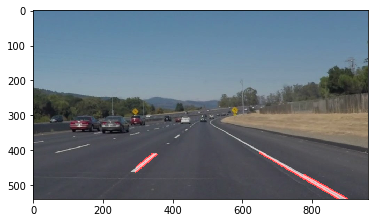

In [6]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image_with_lanes = process_image_hough(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidWhiteCurve-hough.jpg', image_with_lanes)

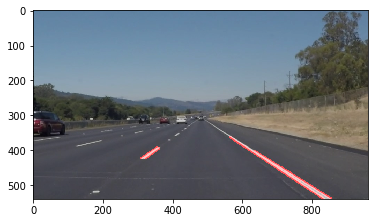

In [7]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_with_lanes = process_image_hough(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidWhiteRight-hough.jpg', image_with_lanes)

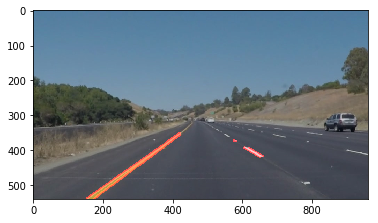

In [8]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image_with_lanes = process_image_hough(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidYellowCurve-hough.jpg', image_with_lanes)

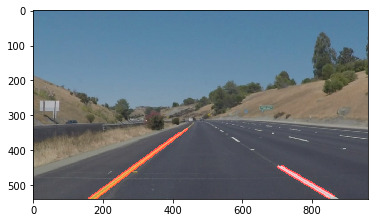

In [9]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_with_lanes = process_image_hough(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidYellowCurve2-hough.jpg', image_with_lanes)

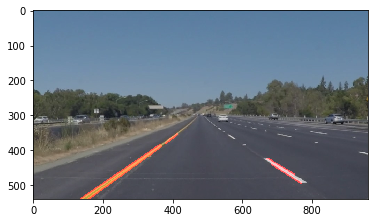

In [10]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image_with_lanes = process_image_hough(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidYellowLeft-hough.jpg', image_with_lanes)

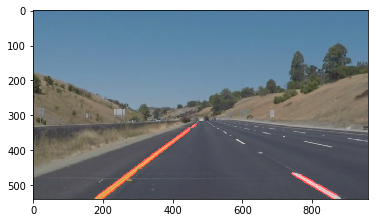

In [11]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image_with_lanes = process_image_hough(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/whiteCarLaneSwitch-hough.jpg', image_with_lanes)

### Solid Lines

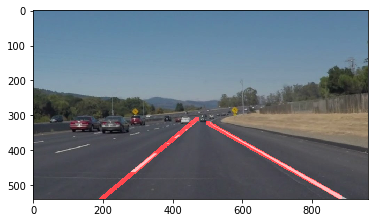

In [12]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image_with_lanes = process_image_solid(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidWhiteCurve-solid.jpg', image_with_lanes)

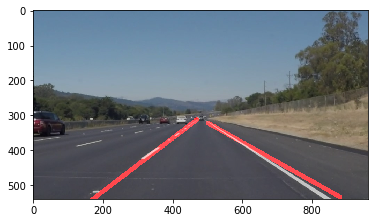

In [13]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_with_lanes = process_image_solid(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidWhiteRight-solid.jpg', image_with_lanes)

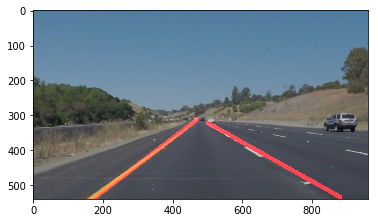

In [14]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image_with_lanes = process_image_solid(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidYellowCurve-solid.jpg', image_with_lanes)

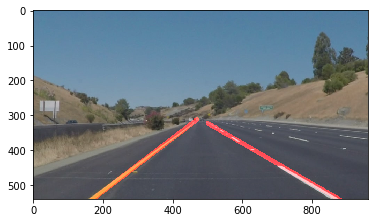

In [15]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_with_lanes = process_image_solid(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidYellowCurve2-solid.jpg', image_with_lanes)

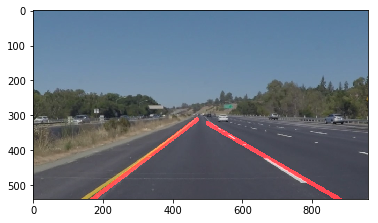

In [16]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image_with_lanes = process_image_solid(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/solidYellowLeft-solid.jpg', image_with_lanes)

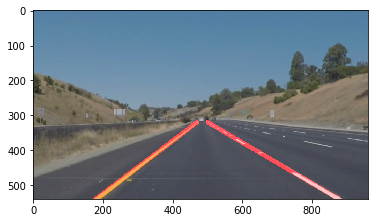

In [17]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image_with_lanes = process_image_solid(image)
plt.imshow(image_with_lanes)
mpimg.imsave('test_images_output/whiteCarLaneSwitch-solid.jpg', image_with_lanes)

## Test on Videos
Inputs in `test_videos` directory.

Output in `test_videos_output` directory.

In [18]:
os.listdir("test_videos/")

['challenge.mp4', 'solidWhiteRight.mp4', 'solidYellowLeft.mp4']

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Hough Segments

In [20]:
white_output = 'test_videos_output/solidWhiteRight-hough.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_hough) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight-hough.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight-hough.mp4


100%|█████████▉| 221/222 [00:05<00:00, 42.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight-hough.mp4 

CPU times: user 2.55 s, sys: 346 ms, total: 2.9 s
Wall time: 5.88 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
yellow_output = 'test_videos_output/solidYellowLeft-hough.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_hough)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft-hough.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft-hough.mp4


100%|█████████▉| 681/682 [00:17<00:00, 38.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft-hough.mp4 

CPU times: user 8.62 s, sys: 1.94 s, total: 10.6 s
Wall time: 18.7 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Solid Lines

In [24]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_solid) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.93 s, sys: 631 ms, total: 3.56 s
Wall time: 7.65 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [26]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_solid)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.74 s, sys: 1.91 s, total: 11.7 s
Wall time: 22.7 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Test on Challenge Video

In [33]:
challenge_output_hough = 'test_videos_output/challenge-hough.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_hough)
%time challenge_clip.write_videofile(challenge_output_hough, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge-hough.mp4
[MoviePy] Writing video test_videos_output/challenge-hough.mp4


100%|██████████| 251/251 [00:12<00:00, 20.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge-hough.mp4 

CPU times: user 5.81 s, sys: 1.73 s, total: 7.54 s
Wall time: 13.9 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_hough))

In [34]:
challenge_output_solid = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
# Works smoother with: 
# Exponentially weighted averaging of hough segments, exp_weighted_average_raw_lines()
challenge_clip = clip3.fl_image(process_image_solid)
%time challenge_clip.write_videofile(challenge_output_solid, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 17.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.12 s, sys: 1.97 s, total: 8.09 s
Wall time: 15 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_solid))